In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from utils.preprocess import get_df, set_data_for_model

In [ ]:
data_path = 'data/data.csv'
df = get_df(data_path)
X_train, X_valid, y_train, y_valid = set_data_for_model(df, 42)

y_train_one_hot = np.eye(2)[y_train]
y_valid_one_hot = np.eye(2)[y_valid]

Epoch 1/100 - loss: 0.6867 - val_loss: 0.6850 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 2/100 - loss: 0.6835 - val_loss: 0.6818 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 3/100 - loss: 0.6788 - val_loss: 0.6787 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 4/100 - loss: 0.6763 - val_loss: 0.6756 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 5/100 - loss: 0.6735 - val_loss: 0.6725 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 6/100 - loss: 0.6675 - val_loss: 0.6689 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 7/100 - loss: 0.6685 - val_loss: 0.6647 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 8/100 - loss: 0.6604 - val_loss: 0.6599 - accuracy: 0.6286 - val_accuracy: 0.6228
Epoch 9/100 - loss: 0.6583 - val_loss: 0.6532 - accuracy: 0.6308 - val_accuracy: 0.6404
Epoch 10/100 - loss: 0.6502 - val_loss: 0.6441 - accuracy: 0.6527 - val_accuracy: 0.6579
Epoch 11/100 - loss: 0.6406 - val_loss: 0.6316 - accuracy: 0.6857 - val_accuracy: 0.7807
Epoch 12/100 - loss: 0.6249 - 

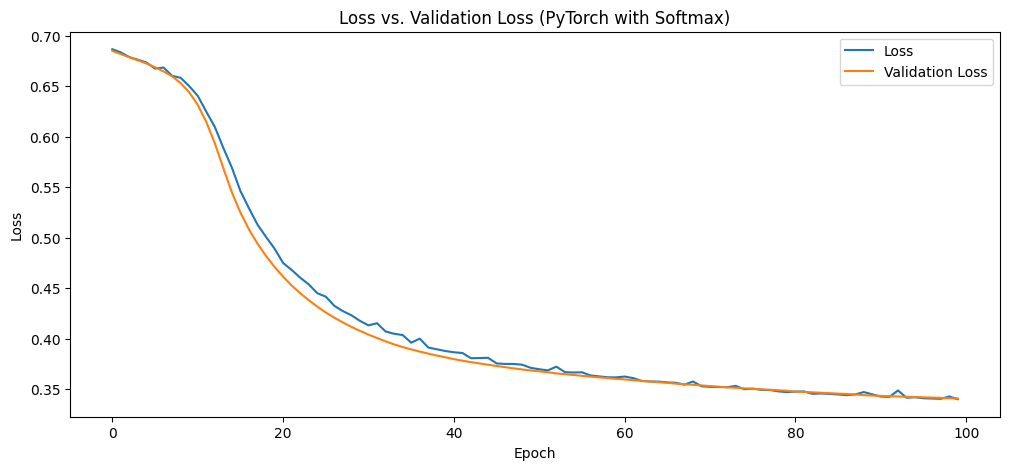

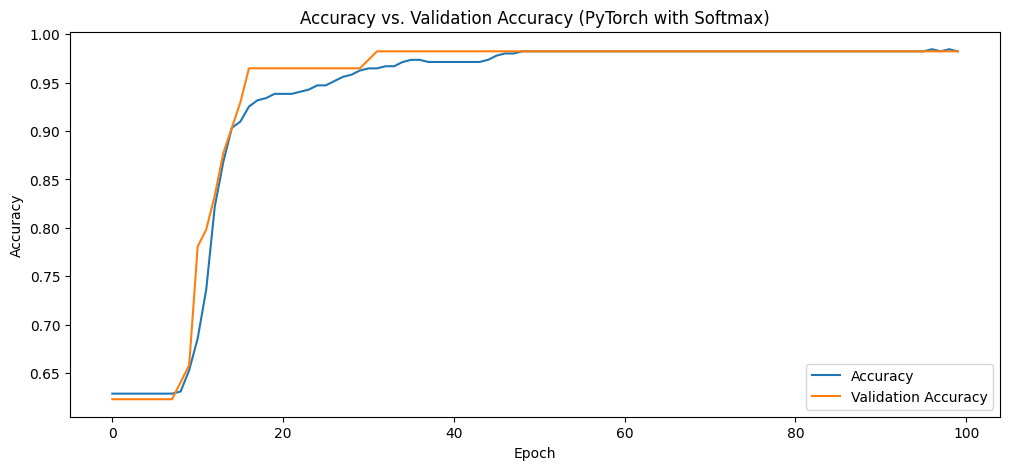

Validation loss: 0.3408
Validation accuracy: 0.9825


In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_one_hot, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_one_hot, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

class MLPModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPModel, self).__init__()
        self.hidden1 = nn.Linear(input_size, 10)
        self.hidden2 = nn.Linear(10, 5)
        self.output = nn.Linear(5, output_size)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.softmax(self.output(x))
        return x

input_size = X_train.shape[1]
output_size = 2
model_pytorch = MLPModel(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pytorch.parameters(), lr=0.035)

def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets.argmax(dim=1)).sum().item()
            total_train += targets.size(0)

        model.eval()
        val_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.argmax(dim=1))
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == targets.argmax(dim=1)).sum().item()
                total_valid += targets.size(0)
        
        train_accuracy = correct_train / total_train
        val_accuracy = correct_valid / total_valid
        history['loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(valid_loader))
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - loss: {history['loss'][-1]:.4f} - val_loss: {history['val_loss'][-1]:.4f} - accuracy: {train_accuracy:.4f} - val_accuracy: {val_accuracy:.4f}")
    
    return history

history_pytorch = train_model(model_pytorch, train_loader, valid_loader, criterion, optimizer, epochs=100)

def evaluate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets.argmax(dim=1)).sum().item()
            total += targets.size(0)
    
    val_loss /= len(valid_loader)
    val_accuracy = correct / total
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")

evaluate_model(model_pytorch, valid_loader, criterion)